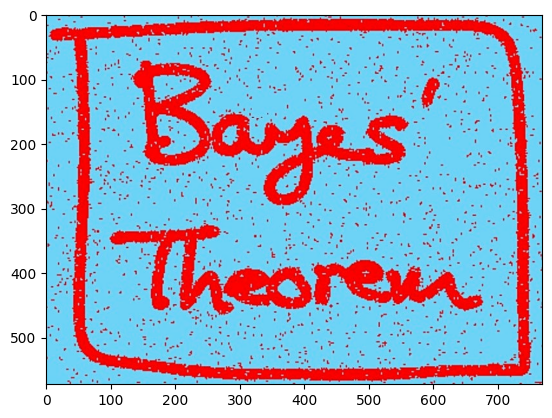

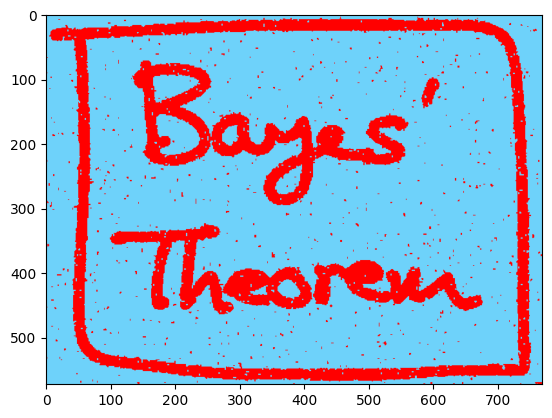

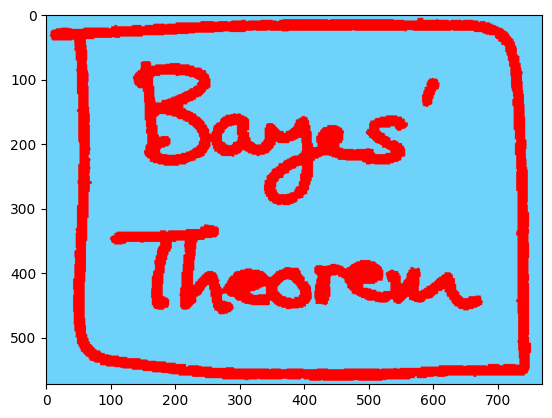

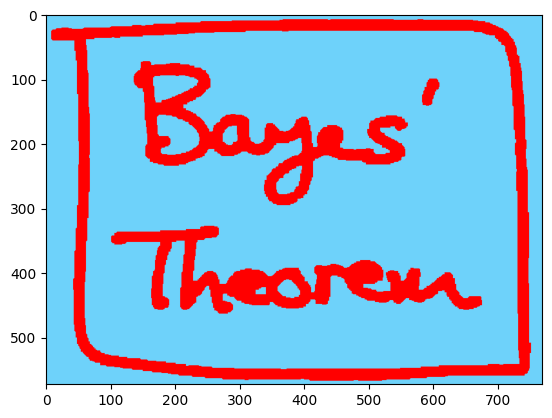

In [7]:
import gco
import skimage.io as io
import numpy as np
import cv2
import matplotlib.pyplot as plt
SOURCE_COLOR = [255, 0, 0]   # blue = foreground
SINK_COLOR = [110, 210, 250]  # yellow = background
Lambda = 0.6  #control the prior weight
img = cv2.imread("bayes_in.jpg")
img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.figure(0)
plt.imshow( img)
for Lambda in (0.2, 0.5, 1):
    unary = np.tile(img_gray[:, :, np.newaxis], [1, 1, 2])
    unary[:, :, 0] = (img_gray - 28)

    unary[:, :, 1] = -(img_gray- 210)

    unary += 255
    smooth = (1 - np.eye(2)) * Lambda
    new_i = gco.cut_grid_graph_simple(unary/255, smooth, n_iter=-1)

    new_image = np.reshape(new_i, img_gray.shape).astype(int)
    denoise_img = np.zeros([img.shape[0], img.shape[1], 3])
    
    # fill color back
    for i in range(new_image.shape[0]):
        for j in range(new_image.shape[1]):
            if new_image[i,j] == 0 :
                denoise_img[i,j,:] =  SOURCE_COLOR
            else :
                denoise_img[i,j, :] = SINK_COLOR

    plt.figure(int(Lambda*10))
    plt.imshow(denoise_img.astype(int))


<font face = "Time New Roman" size = 5>In this part I spend much time to try the "cut_grid_graph_simple" function and several other functions. And then I implement the alogrism according to textbook and class note realize denoise. In the picture above we can see that the noise is reducing with increasing of Lambda. It's reasonaable because the bigger lambda means smoother. Noise can be smoothed. The bigger lambda get a sharper result.</font>

### The codes below are my test scripts. 

In [ ]:
import gco
import numpy as np
import cv2
import matplotlib.pyplot as plt

SOURCE_COLOR = [0, 0, 255 ]   # blue = foreground
SINK_COLOR = [245, 210, 110]  # yellow = background


def dist (c1,c2 ):
    return ( abs( c1[0] - c2[0] )+ \
             abs( c1[1] - c2[1] )+ \
             abs( c1[2] - c2[2] )) / 3; 


m_lambda = 50     # change this value to change the weight of the smoothness or prior term

img = cv2.imread("bayes_in.jpg", cv2.COLOR_BGR2GRAY)
print(img.shape[0:2])

H, W = img.shape[0:2]

edges = np.array([])
unary_cost = np.array([])

for x in range (H):
    for y in range (W):

        c = img[x, y]
        
        if x==0 and y ==0:
            unary_cost = np.array([dist(SOURCE_COLOR, c),dist(SINK_COLOR, c)])
        # data term: 
        else:
            unary_cost = np.vstack((unary_cost, np.array([dist(SOURCE_COLOR, c), dist(SINK_COLOR, c)])))

        # prior term: start
        
        node = x * W + y
        ny = y + 1; # the right neighbor
        next_node_r = x*W + ny

        nx = x + 1; # the below neighbor
        next_node_b = nx*H + y

        if x==0 and y ==0:
            edges = np.array([node, next_node_r])
            edges = np.vstack((edges, np.array([node, next_node_b])))
        # data term: 
        else:
            if x<H-1 and y<W-1:
                edges = np.vstack((edges,np.array([node, next_node_r])))
                edges = np.vstack((edges,np.array([node, next_node_b])))
            else:
                if x == H-1 and y != W-1:
                    edges = np.vstack((edges,np.array([node, next_node_r])))
                else:
                    if y == W-1 and x != H-1:
                        edges = np.vstack((edges,np.array([node, next_node_b])))  
        #graph->add_edge(node, next_node, m_lambda, m_lambda )
        # prior term: end
print(unary_cost.shape)
print(edges.shape)
smooth = (1 - np.eye(2))/m_lambda
tweights = np.zeros([edges.shape[0], 1])

labels = gco.cut_general_graph(edges, tweights, unary_cost, smooth, n_iter=1)
new_image = np.reshape(labels, [H, W])
plt.figure()
plt.imshow(new_image)



[[4.76405235 3.40015721 3.97873798 ... 4.78587049 3.12691209 3.40198936]
 [4.8831507  1.65224094 1.729515   ... 3.82350415 5.16323595 4.33652795]
 [2.63081816 2.76062082 4.0996596  ... 3.58295368 2.60055097 3.37005589]
 ...
 [2.94475621 3.13064302 3.44069106 ... 3.97220715 2.08104952 3.6632405 ]
 [2.8665086  1.43362966 1.25134856 ... 3.0708476  5.43572851 3.9716812 ]
 [2.06703779 5.86520354 1.20795201 ... 3.51687218 2.96707931 4.29811143]]
[[3.23594765 4.59984279 4.02126202 ... 3.21412951 4.87308791 4.59801064]
 [3.1168493  6.34775906 6.270485   ... 4.17649585 2.83676405 3.66347205]
 [5.36918184 5.23937918 3.9003404  ... 4.41704632 5.39944903 4.62994411]
 ...
 [5.05524379 4.86935698 4.55930894 ... 4.02779285 5.91895048 4.3367595 ]
 [5.1334914  6.56637034 6.74865144 ... 4.9291524  2.56427149 4.0283188 ]
 [5.93296221 2.13479646 6.79204799 ... 4.48312782 5.03292069 3.70188857]]


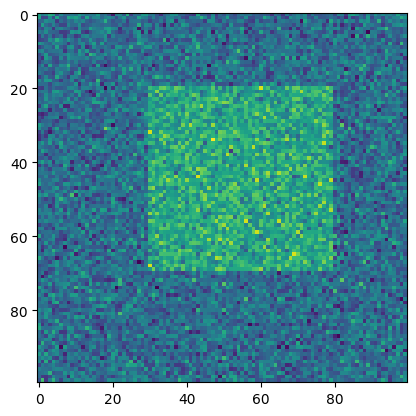

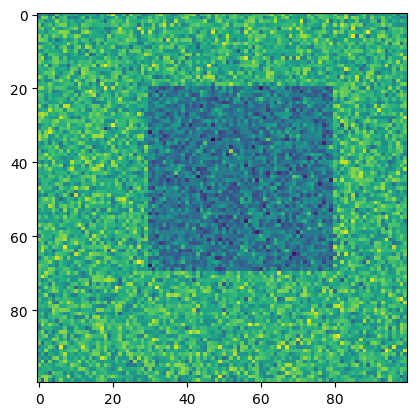

In [1]:
import numpy as np
import matplotlib.pyplot as plt
annot = np.zeros((100, 100))
annot[20:70, 30:80] = 1
np.random.seed(0)
img = np.random.randn(*annot.shape)
img += 2 * annot - 1

# !!! Be careful when doing this concatenation,
# it seems 'c_' does not create a copy
# u = np.c_[img.flatten().copy(), - img.flatten().copy()]

unary = np.tile(img[:, :, np.newaxis], [1, 1, 2])
unary[:, :, 0] = img
unary[:, :, 1] = -img
unary += 4
plt.figure()
plt.imshow(unary[:, :, 0])

